In [2]:
%cd ..

/Users/mateoibarguen/Desktop/DATA-Capstone


In [504]:
from keras.models import load_model
from keras.layers import BatchNormalization, Bidirectional, LSTM, Dropout, Dense, Flatten, Input, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D
from keras.models import Sequential, Model
from models.networks.abstract_models.attention import Attention
from models.networks.abstract_models.base_model import BaseModel
from models.spectra_preprocessor import SpectraPreprocessor
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Autoencoders

In [4]:
spectra_pp = SpectraPreprocessor(dataset_name='set_01', use_generator=False)

In [126]:
X_train, y_train, X_test, y_test = spectra_pp.transform(encoded=False, peak_locations=True)

In [61]:
def transform_peak_locations(peak_locations, mapped_size):
    mapped_array = np.zeros(mapped_size)
    mapped_array[np.round(np.array(peak_locations)*mapped_size).astype(int)] = 1
    return list(mapped_array)

In [522]:
mapped_size = 50
mapped_y_train = np.array([transform_peak_locations(y[0], mapped_size) for y in y_train])
mapped_y_test = np.array([transform_peak_locations(y[0], mapped_size) for y in y_test])

In [523]:
timesteps = 1001
input_dim = 10

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(mapped_size, activation='relu')(inputs)

decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(128, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(1))(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

In [524]:
encoder.compile(optimizer='adam', loss='mse')
encoder.fit(X_train, mapped_y_train, epochs=2)

Epoch 1/2
8500/8500 [==============================] - 104s 12ms/step - loss: 0.0509
Epoch 2/2
8500/8500 [==============================] - 104s 12ms/step - loss: 0.0504


In [525]:
pred = encoder.predict(X_train[:200])

In [538]:
sum(pred[90])

2.7071933167068045

In [533]:
y_train[2]

[[0.5628987310897068, 0.5520067142137278, 0.544022881043424]]

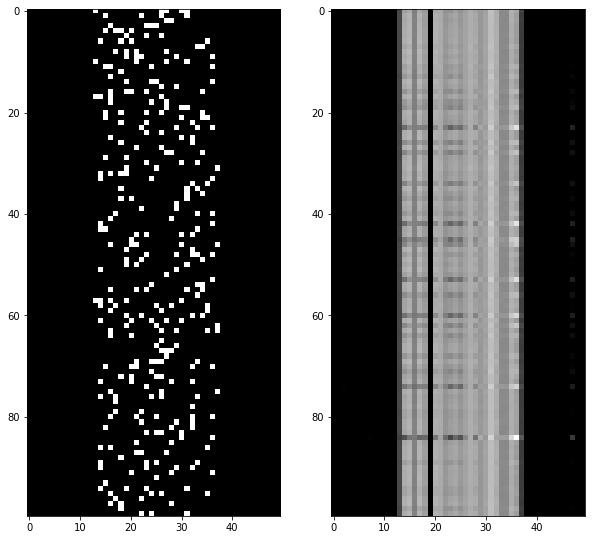

In [541]:
pred = encoder.predict(X_train[:100])
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(mapped_y_train[:100], cmap='gray')
ax[1].imshow(pred, cmap='gray')
plt.show()

In [542]:
model = Sequential()
model.add(BatchNormalization(momentum=0.98, input_shape=(num_timesteps, num_channels)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Attention(num_timesteps))
model.add(Dropout(.5))
model.add(Dense(500, activation='elu'))
model.add(Dropout(.5))
model.add(Dense(mapped_size, activation='softmax'))

In [546]:
#model.compile(optimizer='adam', loss='mse')
#model.fit(X_train, mapped_y_train, epochs=1)

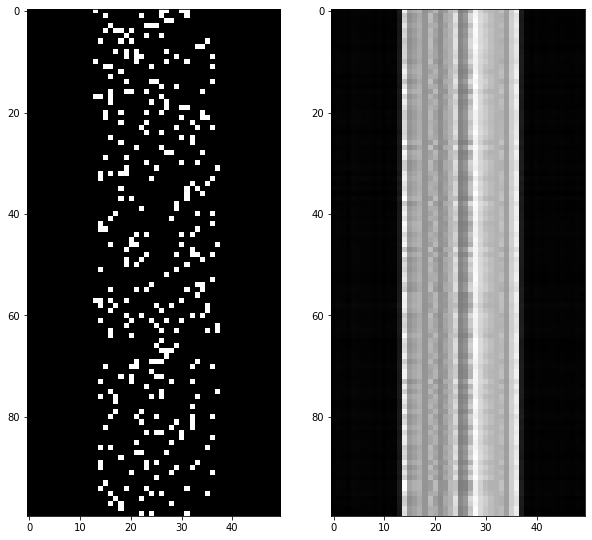

In [545]:
pred = model.predict(X_train[:100])
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(mapped_y_train[:100], cmap='gray')
ax[1].imshow(pred, cmap='gray')
plt.show()

**Maybe we should consider training an object detection model to localize peaks...**